# TikTok data and LLM coding

### Setup 

Run the following cells to set up this notebook

In [ ]:
import ast
from IPython.display import display, clear_output
import json
from ipywidgets import widgets, VBox, HBox, Button, Label, Output
import krippendorff
import pandas as pd
import pyktok as pyk
import random
from openai import OpenAI
import seaborn as sns
import matplotlib.pyplot as plt

from dotenv import load_dotenv

_ = load_dotenv()

In [ ]:
client = OpenAI()

In [ ]:
import nest_asyncio
nest_asyncio.apply()

## Exploring Public Opinion in TikTok Comments

This week we will be exploring TikTok's role in shaping public opinion. Social media has become a popular site of discourse, and platforms like TikTok have been credited for shaping popular culture, politics, and everyday interactions. TikTok comment sections are a site where public opinion is debated and negotiated. At the same time, platform-level decisions alter what comments are most visible on comment pages.

## Choosing a Debate

Create a group of 2 (where at least one person in the group has a TikTok account) and find a video related to popular culture that has discusses two clearly defined positions as a part of a greater debate. This video should also have at least 10k comments. Copy the url of the video and paste it below.

In [ ]:
# Replace with your video URL
video_url = "https://www.tiktok.com/@jimmyonrelationships/video/7286450127701708078?_r=1&_t=ZT-91Gew7Z8evv"

## Scrape Comments!

In [ ]:
async def get_comments():
    pyk.save_tiktok_comments(video_url,
                         comment_count=1000,
                         save_comments=True,
                         return_comments=False,)

await get_comments()

## Define a Research Question
What are you hoping to learn by studying comments on this video?

## research question

Is the conflict stronger rooted in an excess of mental load (as the wife feels) or is it a greater issue of commuication of needs (as the husband feels)? Do the majority of the comments agree with the wife or husband? Alternatively, do they find both partners equally guilty for a lack of communication?

## Defining Concepts
Quantitative content analysis is a popular method for translating non-numeric content into numeric, quantitative data. To do so, researchers create clearly defined and validated concepts. The first step in studying our TikTok debate is clearly defining how each position should be coded.

In [ ]:
concept1 = "Code 1 if the comment agrees with the wife's point of view regarding exhaustion, mental load, and long-term unsustainability (This includes comments that find both parties equally convincing and both in the wrong). Code 0 if the comment does not agree with the wife or if the comment is unrelated to the situation in the video." 

concept2 = "Code 1 if the comment agrees with the husband's point of view regarding a lack of communication of wants and unreasonable expectations. (This includes comments that find both parties equally convincing and both in the wrong). Code 0 if the comment does not agree with the husband or if the comment is unrelated to the situation in the video."

## Let's Code!

In [ ]:
# !!Replace with your filename!!
df = pd.read_csv('@jimmyonrelationships_video_7286450127701708078_comments.csv') 

sample_df = df.sample(n=100, random_state=42).reset_index(drop=True)
text_col = 'text'

for col in ['coder1_concept1', 'coder1_concept2', 'coder2_concept1', 'coder2_concept2']:
    sample_df[col] = None

main_out = Output()
coder1_out = Output()
coder2_out = Output()

def code_entries(coder_label, concept1_col, concept2_col, container_out, next_callback=None):
    index = 0
    text_label = Label(value=sample_df.loc[index, text_col])

    # !!Change the descriptions to your concepts!!
    concept1 = widgets.ToggleButtons(options=[0, 1], description='Concept 1:')
    concept2 = widgets.ToggleButtons(options=[0, 1], description='Concept 2:')
    
    next_button = Button(description='Next →', button_style='success')
    progress = Label(value=f"{coder_label}: {index + 1}/{len(sample_df)}")

    def next_entry(_):
        nonlocal index
        sample_df.loc[index, concept1_col] = concept1.value
        sample_df.loc[index, concept2_col] = concept2.value

        index += 1
        if index < len(sample_df):
            text_label.value = sample_df.loc[index, text_col]
            concept1.value = None
            concept2.value = None
            progress.value = f"{coder_label}: {index + 1}/{len(sample_df)}"
        else:
            container_out.clear_output()
            with container_out:
                display(Label(value=f"{coder_label} has finished coding! ✅"))
                if next_callback:
                    next_callback()
                else:
                    with main_out:
                        print("✅ Both coders finished. Saving data...")
                        sample_df.to_csv('coded_data.csv', index=False)
                        print("💾 Coded data saved to coded_data.csv")

    next_button.on_click(next_entry)

    with container_out:
        container_out.clear_output()
        display(VBox([progress, text_label, concept1, concept2, next_button]))

# ---- Workflow ----

def start_coder2():
    print("\n=== Coder 2: Please start coding ===")
    code_entries("Coder 2", "coder2_concept1", "coder2_concept2", coder2_out)

print(f"Concept 1: {concept1}")
print(f"Concept 2: {concept2}\n")

print("=== Coder 1: Please start coding ===")
code_entries("Coder 1", "coder1_concept1", "coder1_concept2", coder1_out, next_callback=start_coder2)

display(coder1_out, coder2_out, main_out)


## Assess Interrater Reliability

In [336]:
df = pd.read_csv("coded_data.csv")

def krippendorff_alpha_for_concept(df, concept_name):
    data = [
        df[f'coder1_{concept_name}'].tolist(),
        df[f'coder2_{concept_name}'].tolist()
    ]
    return krippendorff.alpha(reliability_data=data, level_of_measurement='nominal')

alpha_concept1 = krippendorff_alpha_for_concept(df, "concept1")
alpha_concept2 = krippendorff_alpha_for_concept(df, "concept2")

print("Krippendorff’s Alpha Scores:")
print(f"• Concept 1: {alpha_concept1:.3f}")
print(f"• Concept 2: {alpha_concept2:.3f}")

Krippendorff’s Alpha Scores:
• Concept 1: 0.620
• Concept 2: 0.468


## Evaluate the interrater reliability and iterate!

![](krippendorff.png)

Describe your interrater reliability. If you scored high, great! How did your concept descriptions help you code effectively? If you scored poorly, what might you have done better?

**Regardless of your score, discuss potential edge cases and improve your concept descriptions**

## Hire a LLM coder!
Write a prompt for an LLM to code the same 100 comments and calculate intercoder reliability. Be sure to tell the LLM their role!

In [40]:
# LLM_prompt = '''You are a research assistant. 
#                 You will receive a series of tiktok comments, 
#                 please code for if the comment supports the wife or the husband.x
#                 Is the conflict stronger rooted in an excess of mental load (as the wife feels) or is it a greater issue of commuication of needs (as the husband feels)? Do the majority of the comments agree with the wife or husband? Alternatively, do they find both partners equally guilty for a lack of communication?
#                 for concept1 = "Code 1 if the comment agrees with the wife's point of view regarding exhaustion, mental load, and long-term unsustainability (This includes comments that find both parties equally convincing and both in the wrong). Code 0 if the comment does not agree with the wife or if the comment is unrelated to the situation in the video." 
#                 for concept2 = "Code 1 if the comment agrees with the husband's point of view regarding a lack of communication of wants and unreasonable expectations. (This includes comments that find both parties equally convincing and both in the wrong). Code 0 if the comment does not agree with the husband or if the comment is unrelated to the situation in the video."
                 
# Here are some examples of correct labeling:

# Example 1
# Text: "It’s like you live in my brain"
# Correct label: ("concept1": 0, "concept2": 0)

# Example 2
# Text: "I feel like a cleaning schedule would help fix this"
# Correct label:("concept1": 0, "concept2": 1)

# Example 3
# Text: "Why do men have to be told what to do 🤔"
# Correct label: ("concept1": 1, "concept2": 0)
# Follow the same reasoning as in the examples when labeling new texts.
#              '''

In [ ]:
# LLM_prompt = '''You are a research assistant coding TikTok comments about a disagreement between a husband and wife.
#                 You will receive a series of tiktok comments, please code for if the comment supports the wife or the husband.
#                 Concept 1 should code 1 for support for wife and/or disagreement with the husband.
#                 Concept 2 should code 1 for support for the husband and/or disagreement with the wife.
#                 Code 0 for either concept 1 or 2 if the comment does not meet the criteria.

#                 Pronouns may be used as an indicator of perspective: If a comment primarily uses feminine pronouns ("she"/"her"/"hers"), interpret the comment as referring to the wife's actions or perspective. 
#                 If a comment primarily uses masculine pronouns ("he"/"his"/"him"), interpret the comment as referring to the husband's actions or perspective.
#                 Pronouns alone do not determine support. Always evaluate the sentiment and reasoning expressed in the comment before assigning a label.
                
#                 Your task is to assign two binary labels (0/1) to each comment, based on whether the comment aligns more with the wife's perspective or the husband's perspective.
                
#                 Is the conflict stronger rooted in an excess of mental load (as the wife feels) or is it a greater issue of commuication of needs (as the husband feels)? Do the majority of the comments agree with the wife or husband? Alternatively, do they find both partners equally guilty for a lack of communication?
#                 for concept1 = "Code 1 if the comment agrees with the wife's point of view regarding exhaustion, mental load, and long-term unsustainability. Code 0 if the comment disagrees the wife's opinions, supports the husband's perspective (support communicate directly), is neutral, or unrelated to the situation." 
#                 for concept2 = "Code 1 if the comment agrees with the husband's point of view regarding a lack of communication of wants and unreasonable expectations. Code 0 if the comment disagrees the husband's opinions, supports the wife’s perspective , is neutral, or unrelated."

#                 concept1 and concept2 are NOT mutually exclusive. A comment can be (1,1) if comments that find both parties equally convincing and both in the wrong. If the comment is unclear, off-topic, joke/meme-only, or not expressing a stance, assign (0,0).

#                 EXAMPLES: "I go through this with husband and two teen boys. the 4 year old is the ONLY one I should be having to do this for🙄", this support the wife opinions because the 4 years old boy should be the only one they have explicitly plan with. should be (1,0)
#                 "Yesssssssssssssss" , this is (0,0) because we cannot see which side it directly support.
#                 "if you think making a list of things you want your partner to do is such a mental load it only means you're useless", this should be the (0,1)
#              ''' 

In [ ]:
# LLM_prompt = '''You are a research assistant coding TikTok comments about a disagreement between a husband and wife. Your task is to classify each comment into one stance category based on who the comment supports.

# There are three possible labels:
# 1. "wife" — The comment supports the wife’s perspective or criticizes the husband.
# 2. "husband" — The comment supports the husband’s perspective or criticizes the wife.
# 3. "neutral" — The comment does not take a side, is a joke, emotional reaction, vague agreement, personal anecdote without blame, or unrelated to the conflict.

# --------------------------------------
# DEFINITIONS
# --------------------------------------

# Label "wife" if the comment:
# - Mentions unequal household labor, mental load, exhaustion, or the wife doing more work
# - Criticizes the husband's effort, initiative, or responsibility
# - Expresses empathy or agreement toward the wife's emotional experience

# Label "husband" if the comment:
# - Suggests the issue is about communication rather than workload
# - Says the wife should clearly express her needs instead of expecting implicit understanding
# - Mocks or dismisses the idea of mental load as the core problem

# Label "neutral" if the comment:
# - Expresses emotion without stance ("same", "lol", "omg", "relatable")
# - Shares a personal story without supporting either side
# - Focuses on general relationship advice unrelated to the disagreement
# - Includes sarcasm or jokes but does not clearly support either side
# - Is too vague to determine stance

# --------------------------------------
# IMPORTANT RULES
# --------------------------------------

# - Assign exactly ONE label per comment: "wife" (1,0), "husband"(0,1), or "neutral"(0,0).
# - Do NOT infer meaning beyond what is written.
# - Pronouns (“he/she”) indicate who the comment refers to, but do not imply support.
# - If unclear, choose "neutral".


# No explanations, no markdown, no extra text.
#              ''' 

## Code with your LLM coder!
For the human coding, agree on a code with your partner for each of the concept

In [ ]:
# text_col = "text"
# sample_df = df.sample(n=100,random_state = 11).reset_index(drop=True)
# sample_df["human_concept1"] = None
# sample_df["human_concept2"] = None

# def code_entries():
#     index = 0
#     out = Output()

#     text_label = widgets.Textarea(value=sample_df.loc[index, text_col], layout=widgets.Layout(width='600px', height='120px'))
#     concept1 = widgets.ToggleButtons(options=[0, 1], description="Concept 1:")
#     concept2 = widgets.ToggleButtons(options=[0, 1], description="Concept 2:")
#     next_button = Button(description="Next →", button_style="success")
#     progress = Label(value=f"Human Coding: {index + 1}/{len(sample_df)}")

#     def next_entry(_):
#         nonlocal index
#         sample_df.loc[index, "human_concept1"] = concept1.value
#         sample_df.loc[index, "human_concept2"] = concept2.value

#         index += 1
#         if index < len(sample_df):
#             text_label.value = sample_df.loc[index, text_col]
#             concept1.value = None
#             concept2.value = None
#             progress.value = f"Human Coding: {index + 1}/{len(sample_df)}"
#         else:
#             clear_output()
#             display(Label(value="✅ Human coding complete! Now AI will code the same sample."))
#             out.clear_output()

#     next_button.on_click(next_entry)
#     display(VBox([progress, text_label, concept1, concept2, next_button, out]))

# code_entries()

In [ ]:
# sample_df.drop_duplicates(subset='cid').to_csv('human_coded_data2.csv')

In [308]:
LLM_prompt = """
You are a research assistant. 
You will receive a series of TikTok comments about a conflict between a wife and a husband.

Your task is to assign two independent binary labels to EACH comment:

- concept1: whether the comment agrees with the wife's perspective
- concept2: whether the comment agrees with the husband's perspective

Background of the conflict:
- The wife’s perspective focuses on exhaustion, mental load, and the long-term unsustainability of the current situation.
- The husband’s perspective focuses on a lack of clear communication of needs and expectations (e.g., “You have to tell me what you want me to do”).

DEFINITIONS

concept1 (wife / mental load):
- Code concept1 = 1 if the comment agrees with the wife's point of view about:
  * exhaustion, mental load, unfair burden of chores or emotional labor,
  * weaponized incompetence, needing to manage the partner like a child,
  * the situation being long-term unsustainable or fundamentally unfair.
- Also code concept1 = 1 if the comment clearly supports both partners being at fault,
  BUT explicitly acknowledges the wife’s mental load, unfairness, or the husband’s incompetence.
- Code concept1 = 0 if the comment does NOT agree with the wife’s perspective,
  OR if the comment is unrelated to the situation.
- Set concept1 = 1 when a comment implies that the husband would not cope
  or function without the wife, or that the wife has to manage or teach him

- Set concept1 = 1 when the commenter clearly agrees that husbands should
  try harder, not "half-ass" chores, or that the wife’s expectations are
  reasonable because of his situation (e.g. staying home all day).

- When a comment explicitly presents BOTH perspectives (for example
  quoting "make a list" AND "don't tell me what to do"), and treats them
  as a conflict, set BOTH concept1 = 1 and concept2 = 1.

- When a commenter says they have the same problem and describes taking
  turns or putting each other in each other's shoes, treat this as
  supporting BOTH perspectives: {"concept1": 1, "concept2": 1}, unless
  they clearly blame only one side.

concept2 (husband / communication):
- Code concept2 = 1 if the comment agrees with the husband's point of view about:
  * the need to clearly communicate wants and expectations,
  * “you have to tell me what to do”, “I can’t know if you don’t ask”,
  * the main issue being miscommunication or unclear expectations.
- Also code concept2 = 1 if the comment clearly supports both partners being at fault,
  BUT emphasizes poor communication, unclear expectations, or mutual responsibility.
- Code concept2 = 0 if the comment does NOT agree with the husband’s perspective,
  OR if the comment is unrelated to the situation.

IMPORTANT NOTES

- The two concepts are INDEPENDENT. All combinations are possible:
  * { "concept1": 1, "concept2": 0 } → sides mainly with the wife / mental load.
  * { "concept1": 0, "concept2": 1 } → sides mainly with the husband / communication.
  * { "concept1": 1, "concept2": 1 } → sees both sides as valid / both at fault.
  * { "concept1": 0, "concept2": 0 } → neutral, unrelated, or only emotional reaction.

When in doubt:
- For rhetorical complaints about chores, unfair mental load, or “men being useless”,
  prefer concept1 = 1.
- For comments that focus on “you have to say what you want”, “you didn’t tell him”,
  or communication problems, prefer concept2 = 1.
- Do NOT set concept1 = 1 for short agreement-only replies such as
  “yes”, “same”, “facts”, “this!”, pure emojis, or @-replies,
  unless there is also a clear description of mental load or incompetence.
- If a comment only says that the speaker has had the same experience
  (e.g. "I just had the same conversation this morning", "same thing
  happened to me") without clearly saying that the wife is right or
  the husband is right, then set:
  {"concept1": 0, "concept2": 0}.
  
Here are some examples of correct labeling. Follow the same reasoning as in the examples
when labeling new texts. When a new text has similar wording or context, you may reuse
the same labels.

Example 1
Text: "It’s like you live in my brain"
Correct label: {"concept1": 0, "concept2": 0}

Example 2
Text: "I feel like a cleaning schedule would help fix this"
Correct label: {"concept1": 0, "concept2": 1}

Example 3
Text: "Why do men have to be told what to do 🤔"
Correct label: {"concept1": 1, "concept2": 0}

Example 4  (Indirect complaint = concept2)
Text: "What do women do when they live alone — scream at the mirror about chores?"
Correct label: {"concept1": 0, "concept2": 1}

Example 5  ("Make a list" sarcasm = concept2)
Text: "make a liiist.... 🎶🎶"
Correct label: {"concept1": 0, "concept2": 1}

Example 6  (Typical weaponized incompetence = concept1)
Text: "then he will intentionally do them wrong... to be right when she has to redo it. mine gives her a bath but never washes her hair."
Correct label: {"concept1": 1, "concept2": 0}

Example 7  (Directive about chores = concept1)
Text: "if you see a chore that can be done, do it; see dirty dishes in the sink, wash them and put them away"
Correct label: {"concept1": 1, "concept2": 0}

Example 8  (Communication excuse = concept1, not concept2)
Text: "Mine got mad at me today because I was tired of cooking and he said, 'how am I supposed to know if you don’t tell me?'"
Correct label: {"concept1": 1, "concept2": 0}

Example 9  (Pure agreement / @-reply)
Text: "Yesssssssssssssss/💯yes yes yes!!/tshhh for real"
Correct label: {"concept1": 0, "concept2": 0}

Example 10 (Agreement with the wife’s complaint)
Text: "FACTS! i feel so Much like the guy!"
Correct label: {"concept1": 0, "concept2": 1}

"""

In [309]:
sample_df = pd.read_csv('human_coded_data2.csv')[:100]

In [310]:
sample_df["human_concept2"] = sample_df["human_concept2"].fillna(1).astype(int)

In [311]:
batch_size = 10

def ai_code_batch(text_list):
    texts_formatted = "\n".join([f"{i+1}. {t}" for i, t in enumerate(text_list)])
    
    prompt = f"""
        {LLM_prompt}
        
        You will receive {len(text_list)} texts.
        
        Return ONLY valid JSON — a list of {len(text_list)} dictionaries like this:
        
        [
          {{"concept1": 1, "concept2": 0}},
          ...
        ]
        
        No explanations, no comments, no extra text — only the JSON array.
        
        Texts:
        {texts_formatted}
        """

    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[{"role": "user", "content": prompt}],
        temperature=0
    )

    try:
        output_text = response.choices[0].message.content.strip()
        batch_json = json.loads(output_text)
        return batch_json  
    except Exception as e:
        try:
            print("Trying to parse")
            output_text = output_text.replace("```", "").replace("json", "").replace("\n", "").strip()
            output_text = output_text.replace("```", "").replace("json", "").replace("\n", "").strip()
            lst = json.loads(output_text)
            print("✅ Parsed successfully.")
            return lst
        except Exception as e:
            print("⚠️ Parsing error:", e)

            return [{"concept1": None, "concept2": None} for _ in text_list]

In [312]:
sample_ai_concept1, sample_ai_concept2 = [], []

for start in range(0, len(sample_df), batch_size):
    print(f"Beginning coding round {batch_size/10}")
    # end = min(start + batch_size, sample_df.shape[0])
    end = start + batch_size
    sample_batch_texts = sample_df[text_col].iloc[start:end].tolist()
    sample_batch_results = ai_code_batch(sample_batch_texts)

    for r in sample_batch_results:
        sample_ai_concept1.append(r.get("concept1"))
        sample_ai_concept2.append(r.get("concept2"))

sample_df["ai_concept1"] = sample_ai_concept1
sample_df["ai_concept2"] = sample_ai_concept2

sample_df.to_csv("ai_coded_data.csv", index=False)
print("✅ Combined human + AI coded data saved to ai_coded_data.csv")


Beginning coding round 1.0
Beginning coding round 1.0
Beginning coding round 1.0
Beginning coding round 1.0
Beginning coding round 1.0
Beginning coding round 1.0
Beginning coding round 1.0
Beginning coding round 1.0
Beginning coding round 1.0
Beginning coding round 1.0
✅ Combined human + AI coded data saved to ai_coded_data.csv


## Evaluate your agreement
Repeat the process until you reach at least 0.7 agreeability with the LLM

In [313]:
def krippendorff_alpha_for_concept(df, concept_name):
    df.dropna(subset='cid', inplace=True)
    data = [
        df[f"human_{concept_name}"].tolist(),
        df[f"ai_{concept_name}"].tolist()
    ]
    return krippendorff.alpha(reliability_data=data, level_of_measurement='nominal')


alpha_c1 = krippendorff_alpha_for_concept(sample_df, "concept1")
alpha_c2 = krippendorff_alpha_for_concept(sample_df, "concept2")

print("Krippendorff’s Alpha between Human and AI:")
print(f"• Concept 1: {alpha_c1:.3f}")
print(f"• Concept 2: {alpha_c2:.3f}")


Krippendorff’s Alpha between Human and AI:
• Concept 1: 0.737
• Concept 2: 0.716


In [314]:
selected = sample_df[["text", "human_concept1", "human_concept2", "ai_concept1", "ai_concept2"]]
df_diff = selected[(selected['ai_concept1'] != selected['human_concept1']) |
             (selected['ai_concept2'] != selected['human_concept2'])]


In [315]:
df_diff

,text,human_concept1,human_concept2,ai_concept1,ai_concept2
0,I do what I think needs done and it gets redon...,0,1,1,0
11,This is why you don’t get married gents. I hav...,0,1,0,0
15,I actually understand the whole “I don’t do it...,0,0,0,1
18,I didn’t grow up with a dish washer so my husb...,0,1,1,0
23,my husband and I had this battle for awhile. I...,1,1,1,0
33,I’ve been telling my OH what to do for 23 year...,0,1,1,0
35,Being told you have been “weaponising incompet...,0,1,1,0
39,honestly it's not that hard to open a YouTube ...,1,0,0,1
42,Well yeah and no. my husband does the dishes a...,0,1,1,0
45,"Oh, if I had a dollar for every time I had thi...",1,0,0,0


## Use your prompt to code the entire comments dataset

In [326]:
# !! Change file name !!
comments = pd.read_csv("@jimmyonrelationships_video_7286450127701708078_comments.csv")

ai_concept1, ai_concept2 = [], []

for start in range(0, len(comments), batch_size):
    print(f"Beginning coding round {(start/10) + 1}")
    end = start + batch_size
    batch_texts = comments[text_col].iloc[start:end].tolist()
    batch_results = ai_code_batch(batch_texts)

    for r in batch_results:
        ai_concept1.append(r.get("concept1"))
        ai_concept2.append(r.get("concept2"))

# Add results to dataframe
comments["ai_concept1"] = ai_concept1
comments["ai_concept2"] = ai_concept2

# Save to file
comments.to_csv("final_coded_data.csv", index=False)
print("✅ Finished Coding!")

Beginning coding round 1.0
Beginning coding round 2.0
Beginning coding round 3.0
Beginning coding round 4.0
Beginning coding round 5.0
Beginning coding round 6.0
Beginning coding round 7.0
Beginning coding round 8.0
Beginning coding round 9.0
Beginning coding round 10.0
Beginning coding round 11.0
Beginning coding round 12.0
Beginning coding round 13.0
Beginning coding round 14.0
Beginning coding round 15.0
Beginning coding round 16.0
Beginning coding round 17.0
Beginning coding round 18.0
Beginning coding round 19.0
Beginning coding round 20.0
Beginning coding round 21.0
Beginning coding round 22.0
Beginning coding round 23.0
Beginning coding round 24.0
Beginning coding round 25.0
Beginning coding round 26.0
Beginning coding round 27.0
Beginning coding round 28.0
Beginning coding round 29.0
Beginning coding round 30.0
Beginning coding round 31.0
Beginning coding round 32.0
Beginning coding round 33.0
Beginning coding round 34.0
Beginning coding round 35.0
Beginning coding round 36.0
B

## Analyze your data

In [327]:
final_coded_data = pd.read_csv("final_coded_data.csv")
# find the metaphor, summarize it and give it llm

#### Exploring quantity of comments

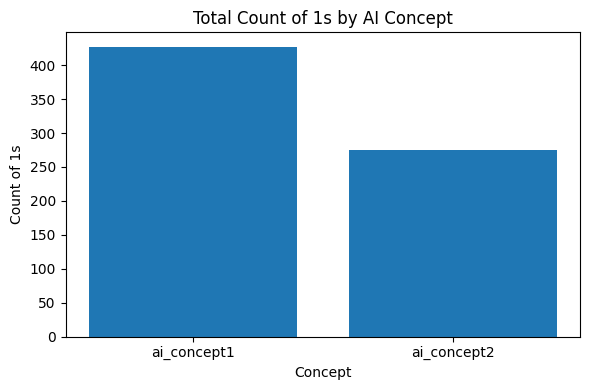

In [328]:
counts = {
    "ai_concept1": final_coded_data["ai_concept1"].sum(),
    "ai_concept2": final_coded_data["ai_concept2"].sum()
}

count_df = pd.DataFrame(list(counts.items()), columns=["Concept", "Total_1s"])

plt.figure(figsize=(6, 4))
plt.bar(count_df["Concept"], count_df["Total_1s"])
plt.title("Total Count of 1s by AI Concept")
plt.ylabel("Count of 1s")
plt.xlabel("Concept")
plt.tight_layout()
plt.show()

#### What comments received more likes?

In [329]:
def collapse(x):
    if x.ai_concept1 == 1:
        return "concept1"
    elif x.ai_concept2 == 1:
        return "concept2"
    else:
        return "neither"

final_coded_data['collapsed_codes'] = final_coded_data.apply(collapse, axis=1)

<Axes: xlabel='digg_count', ylabel='collapsed_codes'>

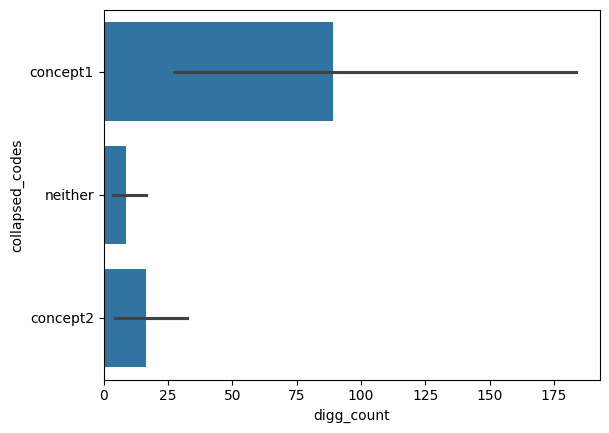

In [330]:
sns.barplot(data=final_coded_data, y='collapsed_codes', x='digg_count')

#### What comments got the most replies?

<Axes: xlabel='reply_comment_total', ylabel='collapsed_codes'>

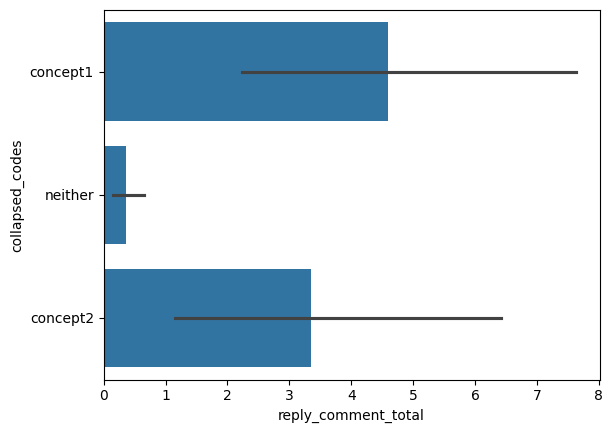

In [331]:
sns.barplot(data=final_coded_data, y='collapsed_codes', x='reply_comment_total')

#### What types of comments are shown more?
This is a visibility metric: higher scores means higher visibility in the comment section

<Axes: xlabel='show_more', ylabel='collapsed_codes'>

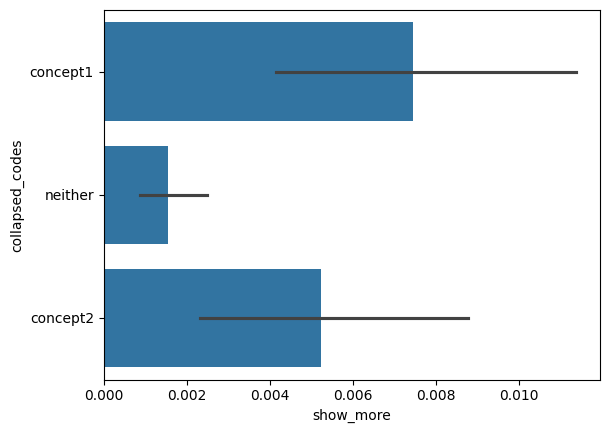

In [335]:
import ast
import pandas as pd
import numpy as np

def parse_sort_extra(x):
    # 1. NaN 直接返回空字典（或你想要的默认值）
    if pd.isna(x):
        return {}
    # 2. 如果本来就是 dict/list，就不用解析
    if isinstance(x, (dict, list)):
        return x
    # 3. 只有是 str 的时候才 literal_eval
    try:
        return ast.literal_eval(x)
    except Exception:
        # 万一有奇怪的脏数据，也给个兜底
        return {}

def get_show_more(d):
    # d 是我们刚才 parse 出来的对象，可能是 dict，也可能是 list
    if isinstance(d, dict):
        return float(d.get("show_more_score", np.nan))
    try:
        d = dict(d)  # 如果是 list of tuples 之类
        return float(d.get("show_more_score", np.nan))
    except Exception:
        return np.nan
final_coded_data["sort_extra_score_loaded"] = final_coded_data["sort_extra_score"].apply(parse_sort_extra)
final_coded_data["show_more"] = final_coded_data["sort_extra_score_loaded"].apply(get_show_more)



sns.barplot(data=final_coded_data, y='collapsed_codes', x='show_more')

#### Are there differences in age between commenters?

In [ ]:
final_coded_data['users_loaded'] = final_coded_data.user.apply(lambda x: ast.literal_eval(x))
final_coded_data['age'] = final_coded_data.users_loaded.apply(
    lambda x: x['predicted_age_group'] if isinstance(x, dict) and 'predicted_age_group' in x else None
)

def reduce(x):
    try:
        return float(x)
    except:
        return float('nan')
final_coded_data['age'] = final_coded_data.age.apply(reduce)


In [ ]:
sns.barplot(data=final_coded_data.dropna(subset='age'), y='collapsed_codes', x='age')

- group -1 = 13-17
- group 1 = 18-24
- group 2 = 25-34
- group 3 = 35-44
- group 4 = 45-54
- group 5 = 55+

#### Use an LLM to create one more visualization or analysis
You might need to inspect your data!

## What does it all mean??
Spend 2-3 paragraphs reflecting on the results from your analysis. What are the implications of this work?